## Real-Time Location System Case Study

### Kevin Okiah, Shravan Kuchkula

## Introduction
Real Time Location System (RTLS) unit is a case study using the data that is available for the Nolan and Lang textbook website: http://rdatasciencecases.org/Data/offline.final.trace.txt

The offline data contains signal strengths measured using a hand-held device on a grid of 166 points spaced 1 meter apart in the hallways of one floor of a building at the University of Mannheim. The floor plan, which measures about 15 meters by 36 meters, is displayed in Figure 1.1. The grey circles on the plan mark the locations where the offline measurements were taken and the black squares mark 6 access points. These reference locations give us a calibration set of signal strengths for the building, and we use them to build our model to predict the locations of the hand-held device when its position is unknown.

![Floor Plan of the Test Environment](rtls_floor_plan.png)

In [63]:
options(digits = 2)
txt = readLines("offline.final.trace.txt")

## Data Cleaning
Each line in the offline file has been read into R as a string in the character vector txt. We have a row in our data frame for each signal received. That is, each line in the input file turns into multiple rows in the data frame, corresponding to the number of ‘;’-separated MAC addresses in that line. For example, the first record in the input file becomes 11 rows and the 2000th observation becomes 8 rows in the data frame.

The documentation for the data describes the format of the data file. The avialable documentation indicates that the format of the data is:

```
t="Timestamp";
id="MACofScanDevice";
pos="RealPosition";
degree="orientation";
MACofResponse1="SignalStrengthValue,Frequency,Mode"; ...
MACofResponseN="SignalStrengthValue,Frequency,Mode"
```

In [64]:
txt[4]

[1] "t=1139643118358;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:0f:a3:39:e1:c0=-53,2462000000,3;00:14:bf:b1:97:8d=-65,2442000000,3;00:14:bf:b1:97:81=-65,2422000000,3;00:14:bf:3b:c7:c6=-66,2432000000,3;00:0f:a3:39:dd:cd=-75,2412000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-87,2437000000,3;02:64:fb:68:52:e6=-88,2447000000,1;02:00:42:55:31:00=-84,2457000000,1"

In addition to the (x,y) coordinates of the hand-held device, the orientation of the device was also provided. Signal strengths were recorded at 8 orientations in 45 degree increments (i.e., 0, 45, 90, and so on).

Further, the documentation for the data indicates that 110 signal strength measurements were recorded to each of the 6 access points for every location-orientation combination.

..... TODO.... more to be added here.

Each t row in converted into a matrix of 11x10 as shown above.

In [65]:
sum(substr(txt, 1, 1) == "#")
length(txt)
strsplit(txt[4], ";")[[1]]
tokens = strsplit(txt[4], "[;=,]")[[1]]
tokens[1:10]
tokens[c(2, 4, 6:8, 10)]
tokens[ - ( 1:10 ) ]

tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], 
                   nrow = nrow(tmp),
                   ncol = 6, 
                   byrow = TRUE), 
            tmp)

dim(mat)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

In [66]:
tmp = lapply(txt[4:20], processLine)

sapply(tmp, nrow)

offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [67]:
dim(offline)

[1] 1181628      10

In [68]:
head(offline)

V1            V2                V3  V4  V5  V6  V7                V8 
1 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:14:bf:b1:97:8a -38
2 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:14:bf:b1:97:90 -56
3 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:0f:a3:39:e1:c0 -53
4 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:14:bf:b1:97:8d -65
5 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:14:bf:b1:97:81 -65
6 1139643118358 00:02:2D:21:0F:33 0.0 0.0 0.0 0.0 00:14:bf:3b:c7:c6 -66
  V9         V10
1 2437000000 3  
2 2427000000 3  
3 2462000000 3  
4 2442000000 3  
5 2422000000 3  
6 2432000000 3

In [69]:
dim(offline)

names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")

# convert numeric columns to numeric.
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

# filter type = 3 rows
offline = offline[ offline$type == "3", ]

# remove type column
offline = offline[ , "type" != names(offline) ]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

[1] 1181628      10

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX         posY           posZ  
 Min.   :2006-02-11 02:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 08:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 14:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 09:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 09:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 15:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

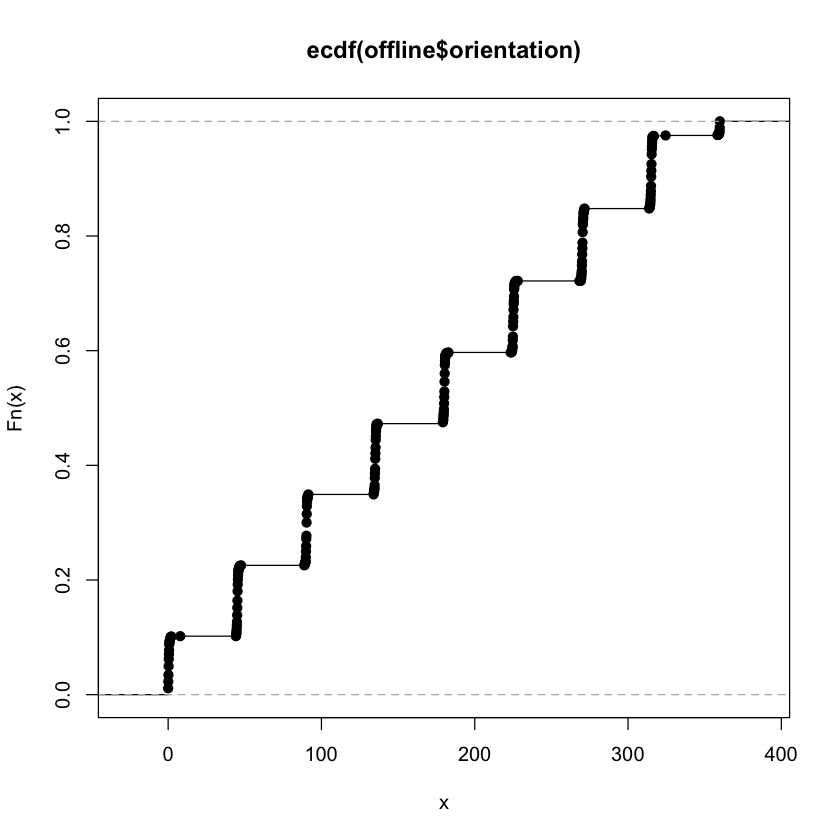

null device 
          1

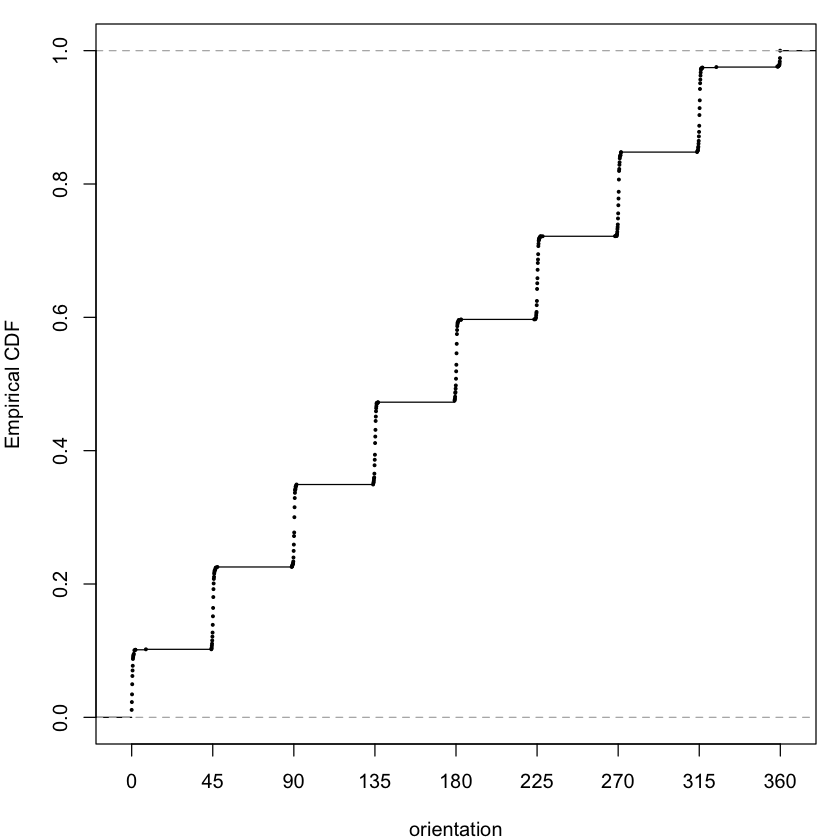

In [70]:
summary(offline[, numVars])

 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

plot(ecdf(offline$orientation))

#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

Warning message:
“In density.default(offline$orientation, bw = 2, sub = "Caption for the figure") :
 extra argument ‘sub’ will be disregarded”

null device 
          1

null device 
          1

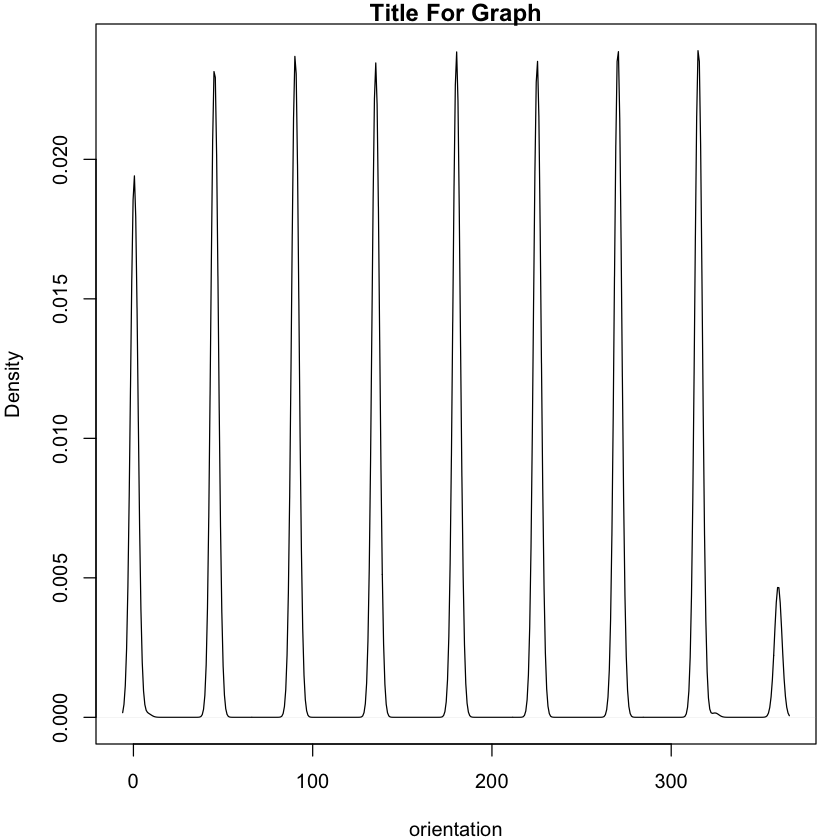

In [71]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2,sub="Caption for the figure"), 
 xlab = "orientation", main = "")
title("Title For Graph")

par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

## Exploring Mac address
### relationship between the MAC address and channel

In [72]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

[1] 12  8

There are 12 MAC addresses and 8 channels. We were given the impression from the building plan (see Figure 1.1) that there are only 6 access points. Why are there 8 channels and 12 MAC addresses? Rereading the documentation we find that there are additional access points that are not part of the testing area and so not seen on the floor plan.

Let’s check the counts of observations for the various MAC addresses with table()

In [73]:
table(offline$mac)


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

Clearly the first and the last two MAC addresses are not near the testing area or were only working/active for a short time during the measurement process because their counts are very low. It’s probably also the case that the third and fifth addresses are not among the access points displayed on the map because they have much lower counts than the others and these are far lower than the possible 146,080 recordings (recall that there are potentially signals recorded at 166 grid points, 8 orientations, and 110 replications). 

According to the documentation, the access points consist of `5 Linksys/Cisco` and `one Lancom L-54g routers`. We look up these MAC addresses at the http://coffer.com/ mac_find/ site to find the vendor addresses that begin with **00:14:bf** belong to **Linksys devices**. Those beginning with *00:0f:a3 belong to Alpha Networks*, and **Lancom devices** start with **00:a0:57**.  

However, none of our MAC addresses begin with 00:a0:57 so there is a discrepancy with the documen- tation. Nonetheless, we have discovered valuable information for piecing together a better understanding of the data. For now, let’s keep the records from the top **7 devices.**

> Question: The floor plan shows six access points; however, the data contains seven access points with roughly the expected number of signals.  In the analysis presented in Nolan and Lang, the access points were matched to their locations, and the decision was made to keep the access point with MAC address 00:0f:a3:39:e1:c0 and to eliminate the data corresponding to MAC address 00:0f:a3:39:dd:cd. 

> Conduct a more thorough data analysis into these two MAC addresses including determining locations by using data corresponding to both MAC addresses.  Which of these two MAC addresses should be used and which should not be used for RTLS? Which MAC address yields the best prediction of location?  Does using data for both MAC addresses simultaneously yield more, or less, accurate prediction of location? (Note: this portion is derived from Exercise Q.9 in Nolan and Lang.)

In [74]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

In [76]:
dim(offline)

[1] 914951      9

In [79]:
head(offline, 20)

time                posX posY orientation mac               signal
1  2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:8a -38   
2  2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:90 -56   
3  2006-02-11 02:31:58 0    0    0           00:0f:a3:39:e1:c0 -53   
4  2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:8d -65   
5  2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:81 -65   
6  2006-02-11 02:31:58 0    0    0           00:14:bf:3b:c7:c6 -66   
7  2006-02-11 02:31:58 0    0    0           00:0f:a3:39:dd:cd -75   
12 2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:8a -38   
13 2006-02-11 02:31:58 0    0    0           00:0f:a3:39:e1:c0 -54   
14 2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:90 -56   
15 2006-02-11 02:31:58 0    0    0           00:14:bf:3b:c7:c6 -67   
16 2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:81 -66   
17 2006-02-11 02:31:58 0    0    0           00:14:bf:b1:97:8d -70   
19 2006-02-11 02:31:58 0    0    0           00:0f:a3:39:dd:cd -73   
22 2006-02-11 02:31:59 0    0    0           00:14:bf:b1:97:8a -38   
23 2006-02-11 02:31:59 0    0    0           00:0f:a3:39:e1:c0 -54   
24 2006-02-11 02:31:59 0    0    0           00:14:bf:b1:97:90 -57   
25 2006-02-11 02:31:59 0    0    0           00:14:bf:b1:97:81 -66   
26 2006-02-11 02:31:59 0    0    0           00:14:bf:3b:c7:c6 -69   
27 2006-02-11 02:31:59 0    0    0           00:14:bf:b1:97:8d -70   
   channel    rawTime angle
1  2437000000 1.1e+12 0    
2  2427000000 1.1e+12 0    
3  2462000000 1.1e+12 0    
4  2442000000 1.1e+12 0    
5  2422000000 1.1e+12 0    
6  2432000000 1.1e+12 0    
7  2412000000 1.1e+12 0    
12 2437000000 1.1e+12 0    
13 2462000000 1.1e+12 0    
14 2427000000 1.1e+12 0    
15 2432000000 1.1e+12 0    
16 2422000000 1.1e+12 0    
17 2442000000 1.1e+12 0    
19 2412000000 1.1e+12 0    
22 2437000000 1.1e+12 0    
23 2462000000 1.1e+12 0    
24 2427000000 1.1e+12 0    
25 2422000000 1.1e+12 0    
26 2432000000 1.1e+12 0    
27 2442000000 1.1e+12 0

Finally, we create a table of counts for the remaining MAC×channel combinations and confirm there is one non-zero entry in each row

In [77]:
macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

Indeed we see that there is a one-to-one correspondence between MAC address and channel for these 7 devices. This means we can eliminate channel from offline, i.e.,

In [80]:
offline = offline[ , "channel" != names(offline)]

Lastly, we consider the position variables, posX and posY. For how many different locations do we have data? The by() function can tally up the numbers of rows in our data frame for each unique (x, y) combination. We begin by creating a list containing a data frame for each location as follows:

In [81]:
locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)

[1] 476

In [83]:
head(locDF)

[[1]]
                    time posX posY orientation               mac signal rawTime
1    2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:8a    -38 1.1e+12
2    2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:90    -56 1.1e+12
3    2006-02-11 02:31:58    0    0           0 00:0f:a3:39:e1:c0    -53 1.1e+12
4    2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:8d    -65 1.1e+12
5    2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:81    -65 1.1e+12
6    2006-02-11 02:31:58    0    0           0 00:14:bf:3b:c7:c6    -66 1.1e+12
7    2006-02-11 02:31:58    0    0           0 00:0f:a3:39:dd:cd    -75 1.1e+12
12   2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:8a    -38 1.1e+12
13   2006-02-11 02:31:58    0    0           0 00:0f:a3:39:e1:c0    -54 1.1e+12
14   2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:90    -56 1.1e+12
15   2006-02-11 02:31:58    0    0           0 00:14:bf:3b:c7:c6    -67 1.1e+12
16   2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:81    -66 1.1e+12
17   2006-02-11 02:31:58    0    0           0 00:14:bf:b1:97:8d    -70 1.1e+12
19   2006-02-11 02:31:58    0    0           0 00:0f:a3:39:dd:cd    -73 1.1e+12
22   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8a    -38 1.1e+12
23   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:e1:c0    -54 1.1e+12
24   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:90    -57 1.1e+12
25   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:81    -66 1.1e+12
26   2006-02-11 02:31:59    0    0           0 00:14:bf:3b:c7:c6    -69 1.1e+12
27   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8d    -70 1.1e+12
30   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:dd:cd    -65 1.1e+12
32   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8a    -38 1.1e+12
33   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:90    -52 1.1e+12
34   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:e1:c0    -54 1.1e+12
35   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:81    -64 1.1e+12
36   2006-02-11 02:31:59    0    0           0 00:14:bf:3b:c7:c6    -68 1.1e+12
37   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8d    -74 1.1e+12
38   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:dd:cd    -78 1.1e+12
43   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8a    -46 1.1e+12
44   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:e1:c0    -55 1.1e+12
45   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:90    -57 1.1e+12
46   2006-02-11 02:31:59    0    0           0 00:14:bf:3b:c7:c6    -67 1.1e+12
47   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:dd:cd    -66 1.1e+12
50   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:81    -66 1.1e+12
52   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8a    -37 1.1e+12
53   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:e1:c0    -54 1.1e+12
54   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:81    -65 1.1e+12
55   2006-02-11 02:31:59    0    0           0 00:14:bf:b1:97:8d    -67 1.1e+12
56   2006-02-11 02:31:59    0    0           0 00:14:bf:3b:c7:c6    -67 1.1e+12
58   2006-02-11 02:31:59    0    0           0 00:0f:a3:39:dd:cd    -67 1.1e+12
62   2006-02-11 02:32:00    0    0           0 00:14:bf:b1:97:8a    -38 1.1e+12
63   2006-02-11 02:32:00    0    0           0 00:0f:a3:39:e1:c0    -54 1.1e+12
64   2006-02-11 02:32:00    0    0           0 00:14:bf:b1:97:90    -56 1.1e+12
65   2006-02-11 02:32:00    0    0           0 00:14:bf:b1:97:8d    -72 1.1e+12
66   2006-02-11 02:32:00    0    0           0 00:0f:a3:39:dd:cd    -73 1.1e+12
68   2006-02-11 02:32:00    0    0           0 00:14:bf:b1:97:81    -65 1.1e+12
71   2006-02-11 02:32:00    0    0           0 00:14:bf:b1:97:90    -55 1.1e+12
72   2006-02-11 02:32:00    0    0           0 00:0f:a3:39:e1:c0    -55 1.1e+12
73   2006-02-11 02:32:00    0    0           0 00:14:bf:3b:c7:c6    -65 1.

Note that this list is longer than the number of combinations of actual (x,y) locations at which measurements were recorded. Many of these elements are empty:

In [84]:
sum(sapply(locDF, is.null))

[1] 310

In [35]:
## Don't run this
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)


sum(sapply(locDF, is.null))



[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

[1] 310

The null values correspond to the combinations of the xs and ys that were not observed. We drop these unneeded elements as follows:

In [85]:
locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

[1] 166

This confirms that we now have only 166 locations. We can operate on each of these data frames to, e.g., determine the number of observa- tions recorded at each location with:

In [86]:
locCounts = sapply(locDF, nrow)

In [87]:
locCounts

[1] 5505 5505 5506 5524 5543 5558 5503 5564 5513 5529 5526 5549 5526 5469 5464
 [16] 5525 5429 5499 5532 5482 5396 5443 5358 5468 5447 5486 5483 5468 5444 5448
 [31] 5503 5496 5472 5533 5459 5493 5543 5481 5539 5527 5490 5522 5433 5554 5463
 [46] 5480 5409 5424 5526 5538 5442 5585 5556 5542 5526 5486 5560 5519 5507 5474
 [61] 5447 5552 5500 5538 5365 5507 5409 5520 5551 5531 5615 5530 5517 5535 5474
 [76] 5483 5541 5447 5506 5513 5519 5499 5576 5492 5473 5426 5529 5567 5528 5553
 [91] 5595 5581 5519 5506 5437 5534 5536 5349 5331 5440 5448 5411 5470 5472 5671
[106] 5541 5514 5543 5452 5527 5543 5593 5540 5531 5539 5621 5624 5495 5450 5500
[121] 5638 5586 5592 5619 5603 5626 5477 5585 5588 5475 5559 5367 5461 5309 5330
[136] 5535 5395 5361 5494 5475 5493 5481 5573 5527 5556 5504 5545 5553 5579 5692
[151] 5540 5492 5487 5589 5463 5596 5557 5488 5523 5656 5524 5544 5734 5523 5553
[166] 5774

And, if we want to keep the position information with the location, we do this with

In [88]:
locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))
class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

[1] "matrix"

[1]   3 166

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
posX  0    1    2    0    1    2    0    1   
posY  0    0    0    1    1    1    2    2   
count 5505 5505 5506 5524 5543 5558 5503 5564

Above we confirm that locCounts is a matrix with 3 rows and we examine a few columns.

We see that there are roughly 5,500 recordings at each position. This is in accord with 8 orientations × 110 replications × 7 access points, which is 6,160 signal strength measurements.

We can visualize all 166 counts by adding the counts as text at their respective locations, changing the size and angle of the characters to avoid overlapping text. We first transpose the matrix so that the locations are columns of the matrix and then we make our plot with

null device 
          1

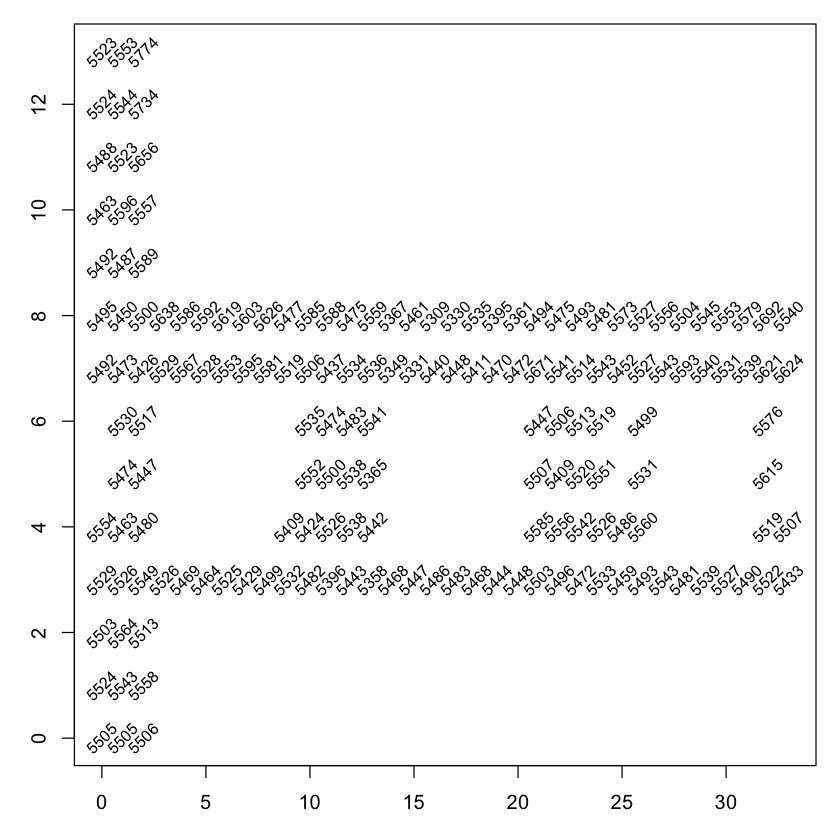

In [89]:
#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

We see in Figure 1.5 that there are roughly the same number of signals detected at each location.

## Creating a function to prepare the data
We have examined all the variables except time and signal. This process has helped us clean our data and reduce it to those records that are relevant to our analysis. We leave the examination of the signals to the next section where we study its distributional properties.

Since we also want to read the online data in R, we turn all of these commands into a function called readData(). Additionally, if we later change our mind as to how we want to handle some of these special cases, e.g., to keep channel or posZ, then we can make a simple update to our function and rerun it. We might even add a parameter to the function definition to allow us to process the data in different ways.

In [90]:
# Function to prepare the data
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

offlineRedo = readData()

identical(offline, offlineRedo)

[1] TRUE

We call `readData()` to create the offline data frame and then we use the `identical()` function to check the version of the data frame against the one that we already created. It returns TRUE. This confirms that our function behaves as expected.

## Signal Strength Analysis
We have used visualization and statistical summaries to help clean and format the data, and now we turn to investigating the properties of the response variable, `signal strength`.

We want to learn more about how the signals behave before designing a model for IPS. The following questions guide us in our investigations:

*We have measured the signal strength to an access point multiple times at each location and orientation. How do these signal strengths behave? That is, what is the distribution of the repeated measurements at each location and orientation? Does signal strength behave similarly at all locations? Or does, the location, orientation, and access point affect this distribution?*

In [95]:
# orientations x measurements x accessPoints
8 * 110 * 6

[1] 5280

### Distribution of Signal Strength
We want to compare the distribution of signal strength at different orientations and for different access points, so we need to subdivide our data. We are interested in seeing if these distributions are normal or skewed. We also want to look at their variances.

We consider the impact of orientation on signal strength by fixing a location on the map to see how the signal changes as the experimenter rotates through the 8 angles.

We also separately examine the MAC addresses because, for example, at an orientation of 90 degrees the experimenter may be facing toward one access point and away from another. To do this we make simple boxplots with the bwplot() function in the lattice package

null device 
          1

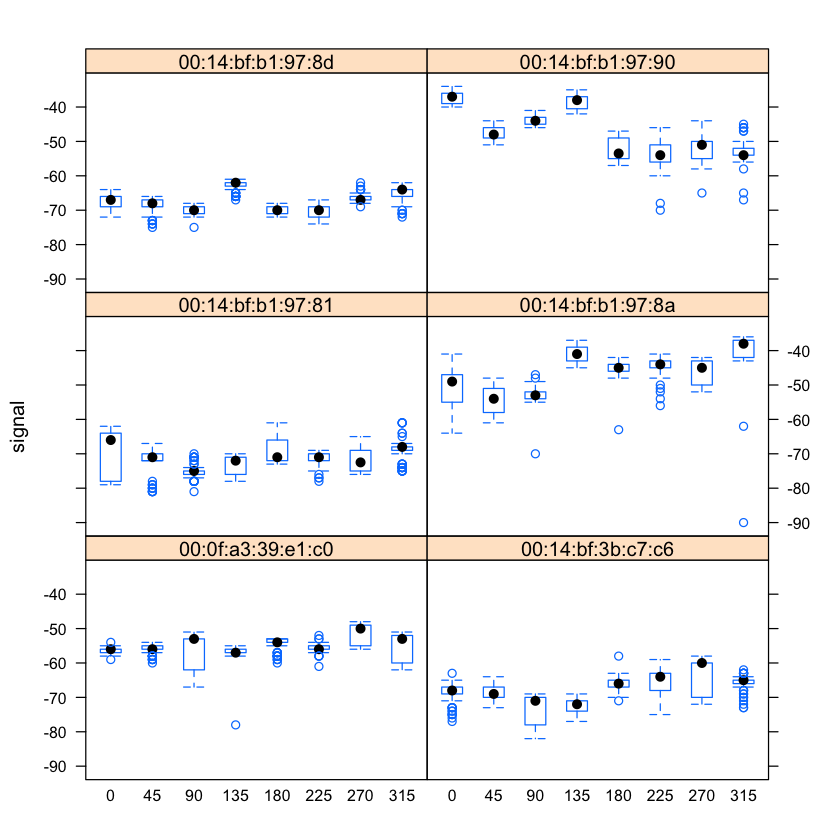

In [96]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, 
       data = offline, 
       subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()

We see in Figure 1.6 that the signal strength varies with the orientation for both close and distant access points.

**Note we have dropped the records for the MAC address of 00:0f:a3:39:dd:cd because it is identified as the extra address in the next section.** 

Recall from the summary statistics that signal strengths are measured in negative values. That is:

In [97]:
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

The small values, such as -98, correspond to weak signals and the large values, such as -25, are the strong signals.

When we examine a few other locations, we find a similar dependence of signal strength on angle. For example, we compare the distributions of signal strength for different angles and MAC addresses at the central location of x = 23 and y = 4; we use the densityplot() function in the lattice package because it makes it easy to condition on these variables. We produce 48 density curves for this one location with

null device 
          1

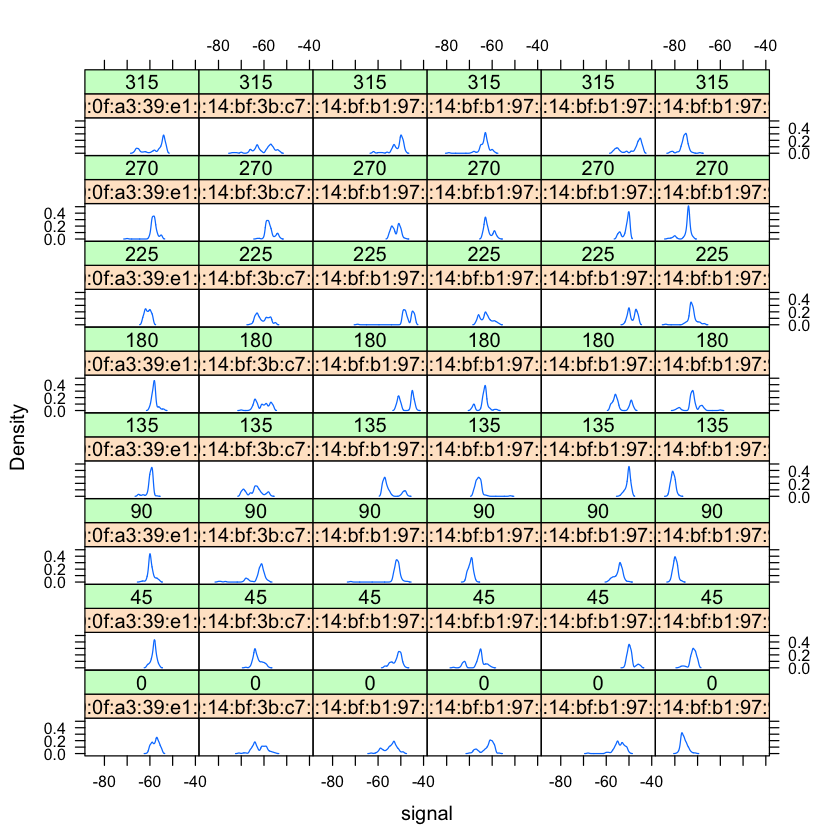

In [98]:
#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

Many of these distributions look approximately normal, but there are some serious departures with secondary modes and skewness (see Figure 1.7). Also, the center of the distri- bution varies with angle and MAC address, which indicates that conditioning on angle and MAC address is warranted. 

If we want to examine the distribution of signal strength for all 166 locations, 8 angles, and 6 access points, we need to create thousands of boxplots or density curves. We can, instead, examine summary statistics such as the mean and SD or the median and IQR of signal strength for all location–orientation–access point combinations.

For each combination, we have roughly 100 observations. To compute summary statistics for these various combinations, we first create a special factor that contains all of the unique combinations of the observed (x, y) pairs for the 166 locations. We can do this with

In [99]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

Next, we create a list of data frames for every combination of (x, y), angle, and access point as follows

In [100]:
byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

Then we can calculate summary statistics on each of these data frames with

In [101]:
signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })
offlineSummary = do.call("rbind", signalSummary) 

Let’s examine the standard deviations and see if they vary with the average signal strength. We can make boxplots of sdSignal for subgroups of avgSignal by turning avgSignal into a categorical variable. We do this with

null device 
          1

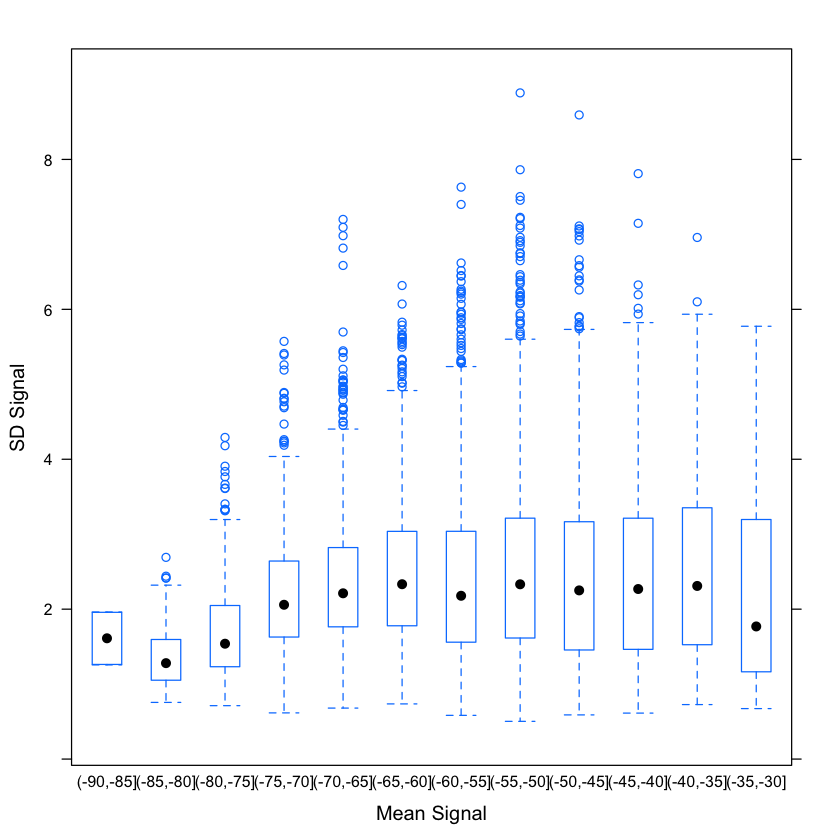

In [102]:
#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

We see in Figure 1.8 that the weakest signals have small standard deviations and that it appears that the SD increases with the average signal strength. If we plan to model the behavior of signal strength, then we want to take these features into consideration.

We examine the skewness of signal strength by plotting the difference, avgSignal - medSignal, against the number of observations. We do this with the smoothScatter() function so that we avoid problems with over plotting and we also add a local average of the difference between the mean and median to better help us assess its size. We use loess() to locally smooth the differences between the mean and median. Then we use the fitted model to predict the difference for each value of num and add these predictions to the scatter plot. 

null device 
          1

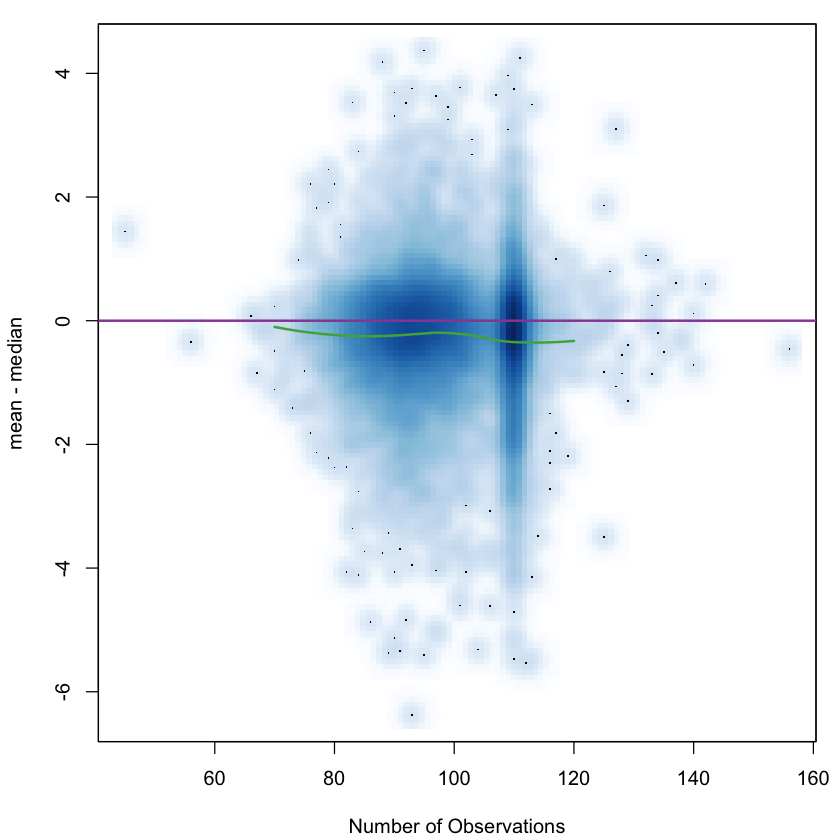

In [103]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()
 
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

From Figure 1.9 we see that these two measures of centrality are similar to each other; they typically differ by less than 1 to 2 dBm.

## Relationship between signal and distance
One way to examine the relationship between distance and signal strength is to smooth the signal strength over the region where it is measured and create a contour plot, similar to a topographical map; that portion of the floor plan where there is strong signal corresponds to the mountainous regions in the contour map. As with our previous analysis of signal strength, we want to control for the access point and orientation. Let’s begin by selecting one MAC address and one orientation to examine.

We can make a topographical map using color, i.e., a heat map. The fields package uses the method of thin plate splines to fit a surface to the signal strength values at the observed locations. This package also provides plotting routines for visualizing the surface with a heat map. The Tps() function in fields requires that we provide a unique “z” value for each (x, y) so we must summarize our signal strengths. Rather than use offline, which gives, in oneAPAngle, about 100 recordings of signal strength at each location, we subset offlineSummary with

In [104]:
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

In [105]:
subMacs[5]

[1] "00:14:bf:b1:97:90"

In [107]:
head(offlineSummary)

time                posX posY orientation mac               signal
7      2006-02-11 02:31:58 0     0   0.0         00:0f:a3:39:dd:cd -75   
24512  2006-02-11 03:03:44 0     1   0.7         00:0f:a3:39:dd:cd -73   
221777 2006-02-11 06:46:02 0    10   0.9         00:0f:a3:39:dd:cd -69   
229191 2006-02-11 06:54:05 0    11   0.4         00:0f:a3:39:dd:cd -72   
236493 2006-02-11 07:02:32 0    12   0.2         00:0f:a3:39:dd:cd -72   
243546 2006-02-11 07:14:12 0    13   0.1         00:0f:a3:39:dd:cd -69   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
7      1.1e+12 0     0-0   -67       -68       111 3.2      4.5      
24512  1.1e+12 0     0-1   -70       -70       110 2.4      3.0      
221777 1.1e+12 0     0-10  -67       -69       111 4.4      6.5      
229191 1.1e+12 0     0-11  -73       -74       111 5.4      7.0      
236493 1.1e+12 0     0-12  -70       -70       114 2.4      3.0      
243546 1.1e+12 0     0-13  -74       -74       109 3.5      4.0

In [108]:
# one AP - Access Point and one Angle/Orientation
# Access point we chose here is 00:14:bf:b1:97:90 and angle is 0
head(oneAPAngle)

time                posX posY orientation mac               signal
2      2006-02-11 02:31:58 0     0   0.0         00:14:bf:b1:97:90 -56   
24508  2006-02-11 03:03:44 0     1   0.7         00:14:bf:b1:97:90 -58   
221773 2006-02-11 06:46:02 0    10   0.9         00:14:bf:b1:97:90 -48   
229195 2006-02-11 06:54:05 0    11   0.4         00:14:bf:b1:97:90 -50   
236490 2006-02-11 07:02:32 0    12   0.2         00:14:bf:b1:97:90 -56   
243540 2006-02-11 07:14:12 0    13   0.1         00:14:bf:b1:97:90 -62   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
2      1.1e+12 0     0-0   -56       -56       104 1.2      1        
24508  1.1e+12 0     0-1   -57       -57        94 3.4      3        
221773 1.1e+12 0     0-10  -48       -49       105 1.7      2        
229195 1.1e+12 0     0-11  -52       -52       104 3.8      3        
236490 1.1e+12 0     0-12  -55       -55        98 2.1      1        
243540 1.1e+12 0     0-13  -56       -56       104 2.9      1

Then, after loading fields, we call Tps() to fit a smooth surface to mean signal strength. Next, we use predictSurface() to predict the value for the fitted surface at a grid of the observed posX and posY values. Then we plot the predicted signal strength values using `plot.surface()`. Lastly, we add the locations where the measurements were taken.

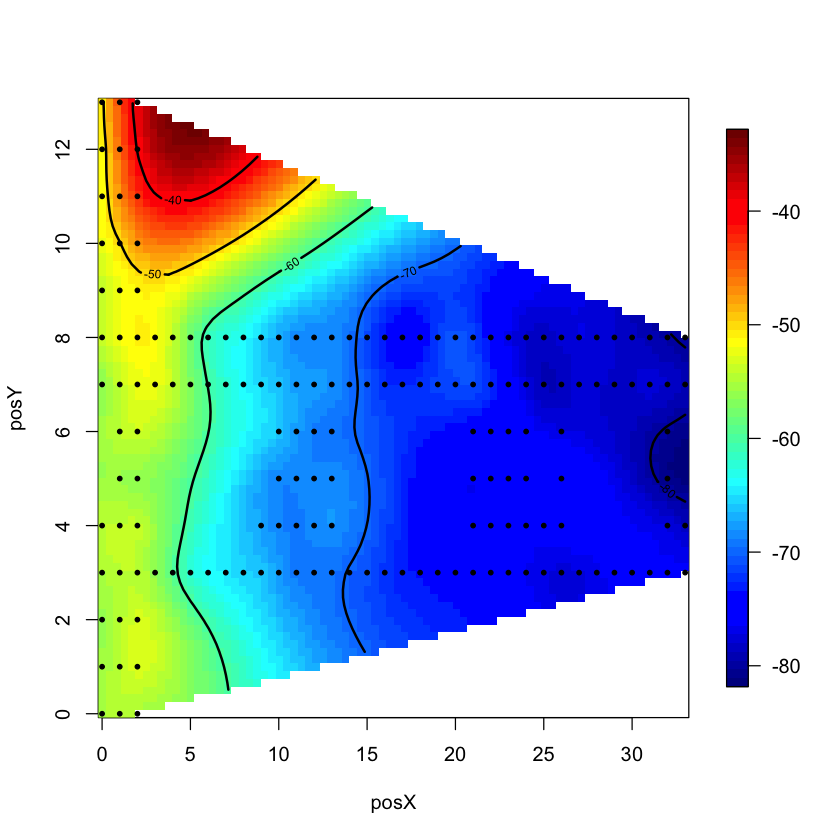

In [109]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

In [43]:
# load required packages
# Use pacman to load packages. 
# Running this for the first time might take time depending on whether
# these packages are already installed or not. 
install.packages("pacman", repos = "http://cran.us.r-project.org")
pacman::p_load(pacman,tidyverse, dplyr, 
               ggplot2, fields, lattice)


The downloaded binary packages are in
	/var/folders/s_/d5qfzls10sz1z696lmcpvtfw0000gn/T//RtmpnadT9I/downloaded_packages


also installing the dependencies ‘dotCall64’, ‘spam’




The downloaded binary packages are in
	/var/folders/s_/d5qfzls10sz1z696lmcpvtfw0000gn/T//RtmpnadT9I/downloaded_packages



fields installed


In [45]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

We can wrap this plotting routine into its own function so that we can parameterize the MAC address and angle, and if desired, other plotting parameters. Our function, called `surfaceSS()` has 3 arguments:
- data for the offline summary data frame
- mac address
- angle

which supply the MAC address and angle to select the subset of the data that we want smoothed and plotted.

We call surfaceSS() with a couple of MAC addresses and angles to compare them. To do this, we first modify R’s plotting parameters so that we can place 4 contour plots on one canvas, and we reduce the size allocated to the margins so more of the canvas is dedicated to the heat maps. We save the current settings for the plotting parameters in parCur with

In [111]:
subMacs[ rep(c(5, 1), each = 2) ]

[1] "00:14:bf:b1:97:90" "00:14:bf:b1:97:90" "00:0f:a3:39:e1:c0"
[4] "00:0f:a3:39:e1:c0"

ERROR while rich displaying an object: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.list(obj)
9. repr_list_generic(obj, "html", "\t<li>%s</li>\n", "\t<dt>$%s</dt>\n\t\t<dd>%s</dd>\n", 
 .     "<strong>$%s</strong> = %s", "<ol>\n%s</ol>\n", "<dl>\n%s</dl>\n", 
 .     numeric_item = "\t<dt>[[%s]]</dt>\n\t\

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


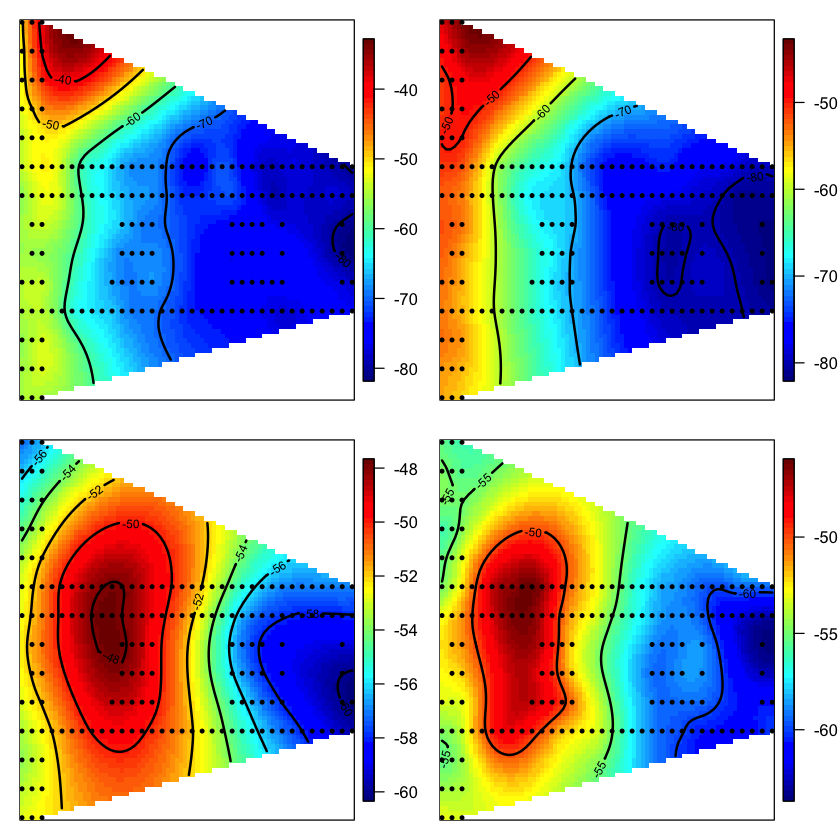

In [110]:
# define function
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

Figure 1.10: Median Signal at Two Access Points and Two Angles. These four heat maps provide a smooth topographical representation of signal strength. The top two maps are for the access point 00:14:bf:b1:97:90 and the angles 0 (left) and 135 (right). The two bottom heat maps represent the signal strength for the 00:0f:a3:39:e1:c0 and the same two angles.

In Figure 1.10 we see that we can easily identify the location of the access point as the dark red region at the top of the “mountain.” We also confirm the effect of the orientation on signal strength. Additionally, a corridor effect emerges. The signal is stronger relative to distance along the corridors where the signals are not blocked by walls.

> We know the locations of the access points based on the floor plan of the building, but we have not been given their exact location and we do not know the mapping between MAC address and access point. Fortunately, the contour maps that we just created make it easy to connect the MAC address to the access point marked on the floor plan in Figure 1.1. 

> For example, from Figure 1.10, the signals appearing in the top row of the plot clearly correspond to the access point in the top left corner of the building. 

> Also, according to the documentation, the training data were measured at 1 meter intervals in the building so we can use the grey dots on the plan to estimate the location of the access points. We find that two MAC addresses have similar heat maps and these both correspond to the access point near the center of the building (i.e., x = 7.5 and y = 6.3).

ERROR while rich displaying an object: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.list(obj)
9. repr_list_generic(obj, "html", "\t<li>%s</li>\n", "\t<dt>$%s</dt>\n\t\t<dd>%s</dd>\n", 
 .     "<strong>$%s</strong> = %s", "<ol>\n%s</ol>\n", "<dl>\n%s</dl>\n", 
 .     numeric_item = "\t<dt>[[%s]]</dt>\n\t\

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

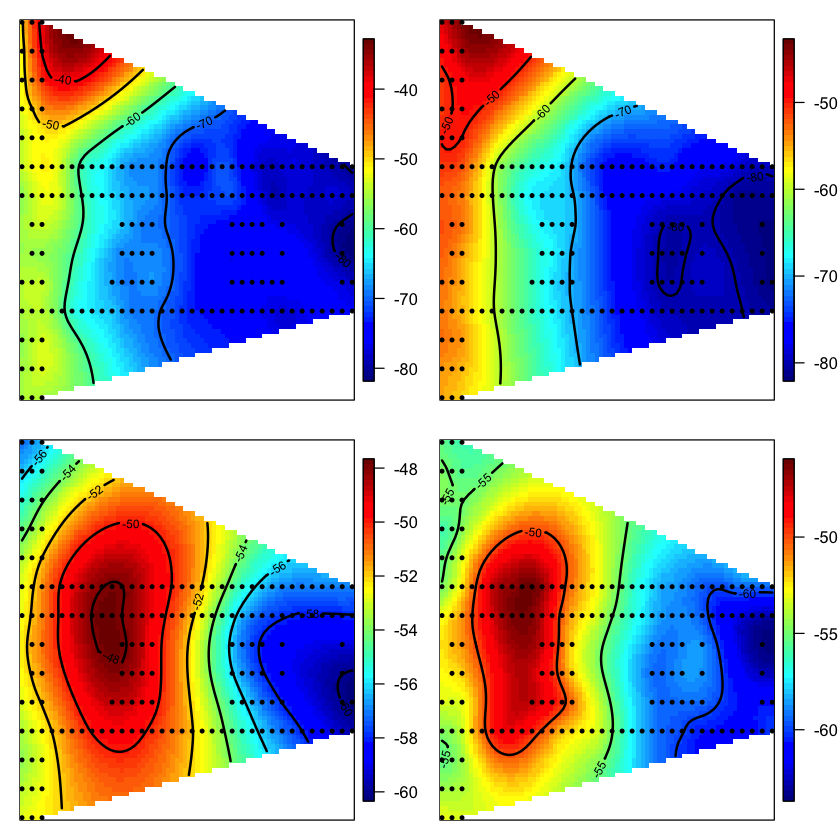

In [46]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

To examine the relationship between signal strength and distance from the access point,
we need to compute the distances from the locations of the device emitting the signal to the access point receiving the signal. We first compute the difference between the x coordinate and access point’s x coordinate and the similar difference for the y coordinates. We do this with

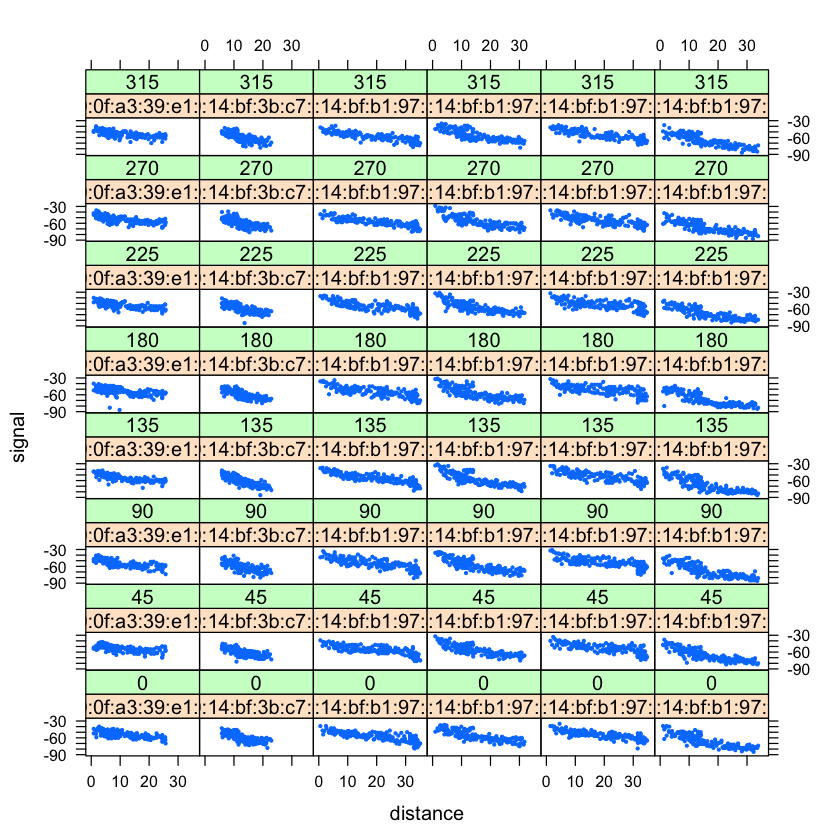

null device 
          1

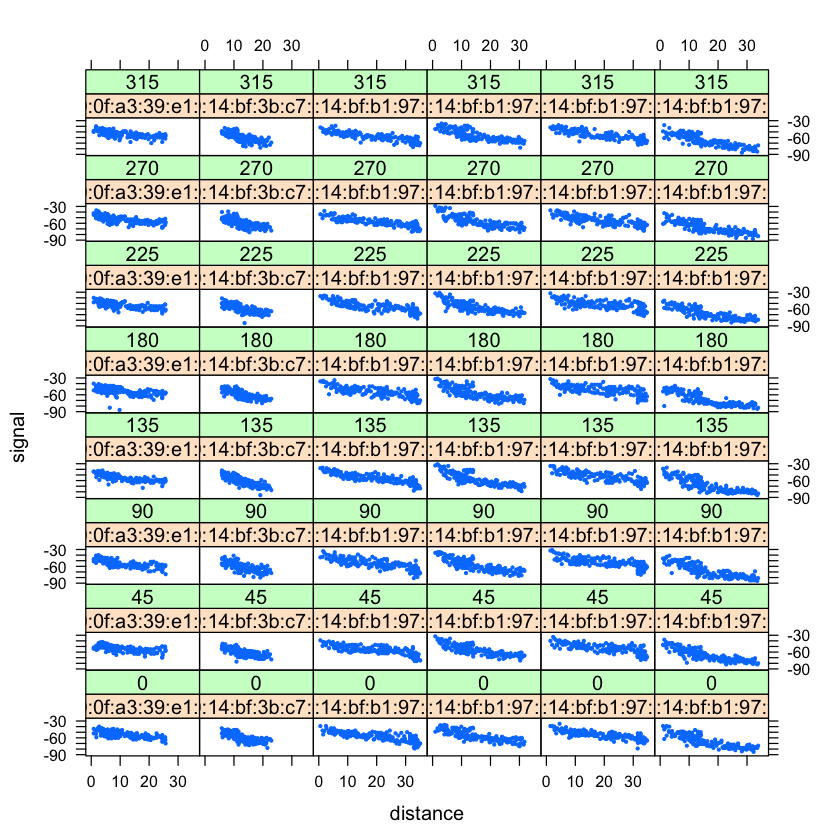

In [47]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

In [49]:
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  



[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

In [50]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [51]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [52]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [53]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}



posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52               -66               -63              
0-1  0-1   0     1   -53               -65               -64              
0-10 0-10  0    10   -56               -66               -69              
0-11 0-11  0    11   -55               -67               -70              
0-12 0-12  0    12   -56               -70               -72              
0-13 0-13  0    13   -55               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

[1] 166

In [54]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)



In [55]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

null device 
          1

[1] 659 307

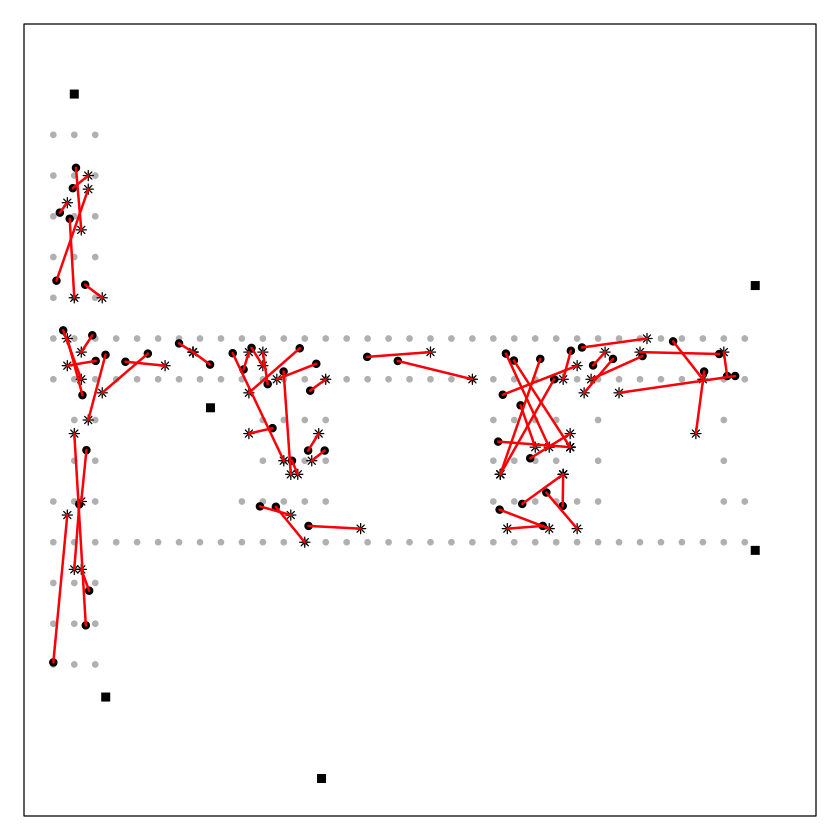

In [56]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

In [57]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

In [58]:
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

In [59]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

[1] 64

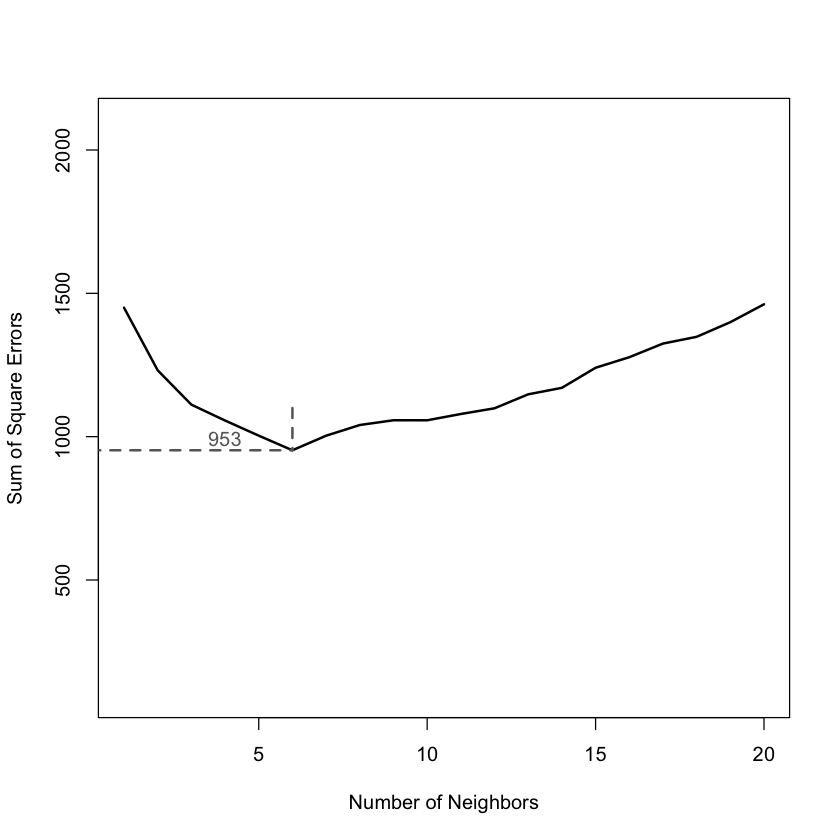

In [60]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()

In [61]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 276

In [62]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}